The purpose of this Jupyter Notebook is to a) generate a unified dataset of fire perimeters including fire cause and b) update the available information about the percentage of area burned from lightning-ignited vs. human-caused fires.

In [ ]:
from pathlib import Path
import geopandas as gp
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

### 1. Create data files with fire cause and aggregate

Load fire perimeter and point data from Alaska Interagency Coordination Center (AICC) https://fire.ak.blm.gov/predsvcs/maps.php

In [ ]:
datadir = Path(r'/data')
ptsfile = 'ALFD_3338_Points_current.gpkg'
perifile = 'ALFD_3338_current.gpkg'

Perimeter-file columns. Fires are identified by multiple ID properties, which all have different levels of completeness. We will use `AFSNUMBER`, `DOFNUMBER`, and `USFSNUMBER`. 

In [ ]:
gp.read_file(datadir / perifile).columns

Index(['OBJECTID', 'NAME', 'RECORDNUMBER', 'ACRES', 'AFSNUMBER', 'DOFNUMBER',
       'USFSNUMBER', 'ADDNUMBER', 'PERIMETERDATE', 'LATESTPERIMETER', 'SOURCE',
       'SOURCEMETHOD', 'SOURCECLASS', 'AGENCYACRES', 'ACREAGEMETHOD',
       'COMMENTS', 'FIREID', 'FIREYEAR', 'UPDATETIME', 'UPDATEUSER',
       'USEDONFINALREPORT', 'FPOUTDATE', 'FPMERGEDDATE', 'IRWINID',
       'PRESCRIBED', 'FIRESEASONS', 'geometry'],
      dtype='object')

We keep all fire perimeters with a size larger than 1 acre.

In [ ]:
periDF = gp.read_file(datadir / perifile)[['NAME', 'ACRES', 'AFSNUMBER', 'DOFNUMBER', 'USFSNUMBER', 'FIREYEAR',  'geometry']]
periDF = periDF[periDF.ACRES >= 1.0]
periDF

,NAME,ACRES,AFSNUMBER,DOFNUMBER,USFSNUMBER,FIREYEAR,geometry
0,Tiinkdhul Lake,345.4,EA9L,None,None,2008,"MULTIPOLYGON (((479573.392 1883508.253, 479573..."
1,McKinley River,77.9,DMQ6,None,None,2007,"MULTIPOLYGON (((132532.288 1517468.512, 132511..."
2,Kateel River,343.4,DP8D,None,None,2007,"MULTIPOLYGON (((-206380.674 1730074.245, -2063..."
3,Alatna Hills,218.9,DJ69,731317,None,2007,"MULTIPOLYGON (((52029.158 1885176.582, 52054.9..."
4,Slate Creek,191.4,DJY0,None,None,2007,"MULTIPOLYGON (((176711.918 1919243.981, 176875..."
...,...,...,...,...,...,...,...
5399,032007,189.4,A020,032007,None,1990,"MULTIPOLYGON (((-295372.69 1820580.228, -29511..."
5400,031033,61.0,A299,031033,P02053,1990,"MULTIPOLYGON (((273087.7 1723426.705, 273131.0..."
5401,FYU S 102,24.8,A191,None,None,1990,"MULTIPOLYGON (((284749.345 1715287.849, 284797..."
5402,CEM W 76,14.9,A340,None,P01075,1990,"MULTIPOLYGON (((294745.764 1713629.371, 294687..."


Columns for the points dataset. This dataset is much messier and has all extra information, including `FIRECAUSE`. Note that `FIREYEAR` in the perimeters dataset is called `FIRESEASON` here. 

In [ ]:
gp.read_file(datadir / ptsfile).columns

Index(['OBJECTID', 'ID', 'NAME', 'FIRESEASON', 'LASTUPDATETIME', 'MGMTORGID',
       'MGMTOFFICEID', 'MGMTOPTIONID', 'PRESCRIBEDFIRE', 'LATITUDE',
       'LONGITUDE', 'MAPNAME', 'MAPNUMBER', 'NEARESTWEATHERSTA',
       'ORIGINOWNERID', 'ORIGINADMINUNITID', 'DISCOVERYDATETIME',
       'DISCOVERYSIZE', 'IADATETIME', 'IASIZE', 'INITIALBEHAVIOR',
       'CONTROLDATETIME', 'OUTDATE', 'ESTIMATEDTOTALACRES', 'ACTUALTOTALACRES',
       'ESTIMATEDTOTALCOST', 'GENERALCAUSE', 'SPECIFICCAUSE', 'ORIGINSLOPE',
       'ORIGINASPECT', 'ORIGINELEVATION', 'ORIGINTOWNSHIP', 'ORIGINRANGE',
       'ORIGINSECTION', 'ORIGINQUARTER', 'ORIGINMERIDIAN',
       'STRUCTURESTHREATENED', 'STRUCTURESBURNED', 'PRIMARYFUELTYPE',
       'HARDCOPYREPORTAVAILABLE', 'TYPE1ASSIGNEDDATE', 'TYPE1RELEASEDDATE',
       'TYPE2ASSIGNEDDATE', 'TYPE2RELEASEDDATE', 'AFSNUMBER', 'DOFNUMBER',
       'USFSNUMBER', 'ADDITIONALNUMBER', 'FALSEALARM', 'FORCESITRPT',
       'FORCESITRPTSTATUS', 'RECORDNUMBER', 'COMPLEX', 'IMPORT_NOTES',
  

Similarly, we keep all the fire points (inition points of individual fire events) with areas > 1 acre associated.

In [ ]:
ptsDF = gp.read_file(datadir / ptsfile)[
    ['FIRECAUSE', 'AFSNUMBER', 'DOFNUMBER', 'USFSNUMBER', 'FIRESEASON', 'ESTIMATEDTOTALACRES']]
ptsDF = ptsDF[ptsDF.ESTIMATEDTOTALACRES >= 1.0]
ptsDF

,FIRECAUSE,AFSNUMBER,DOFNUMBER,USFSNUMBER,FIRESEASON,ESTIMATEDTOTALACRES
0,Human,B002,103002,None,2001,2.0
2,Human,None,201011,None,2002,1.5
8,Human,None,203020,None,2002,6.5
15,Natural,B193,104193,None,2001,5.0
18,Natural,B197,111197,None,2001,20.0
...,...,...,...,...,...,...
35100,Natural,QHG3,311286,PNQHG3,2023,1409.8
35104,Natural,None,311384,None,2023,1.0
35107,Human,None,000306(1),None,2023,58.0
35111,Natural,QJH6,None,PDQJH6,2023,12.2


There are multiple ID keys that the fire service is using. Unfortunately the key sets are not complete over time. So we'll use `AFSNUMBER`, `DOFNUMBER` and `USFSNUMBER` to create three separate dataframes, and then merge them.

In [ ]:
merged = []

In [ ]:
joinedDF = periDF[['NAME', 'ACRES', 'AFSNUMBER', 'FIREYEAR',  'geometry']].dropna().merge(
    ptsDF[['FIRECAUSE', 'AFSNUMBER', 'FIRESEASON']], how='inner', 
    left_on=['AFSNUMBER', 'FIREYEAR'], right_on=['AFSNUMBER', 'FIRESEASON']).drop_duplicates()
merged.append(joinedDF.drop(columns=['AFSNUMBER']))
joinedDF

,NAME,ACRES,AFSNUMBER,FIREYEAR,geometry,FIRECAUSE,FIRESEASON
0,Tiinkdhul Lake,345.4,EA9L,2008,"MULTIPOLYGON (((479573.392 1883508.253, 479573...",Natural,2008
1,McKinley River,77.9,DMQ6,2007,"MULTIPOLYGON (((132532.288 1517468.512, 132511...",Natural,2007
2,Kateel River,343.4,DP8D,2007,"MULTIPOLYGON (((-206380.674 1730074.245, -2063...",Natural,2007
3,Alatna Hills,218.9,DJ69,2007,"MULTIPOLYGON (((52029.158 1885176.582, 52054.9...",Natural,2007
4,Slate Creek,191.4,DJY0,2007,"MULTIPOLYGON (((176711.918 1919243.981, 176875...",Natural,2007
...,...,...,...,...,...,...,...
5041,032007,189.4,A020,1990,"MULTIPOLYGON (((-295372.69 1820580.228, -29511...",Natural,1990
5042,031033,61.0,A299,1990,"MULTIPOLYGON (((273087.7 1723426.705, 273131.0...",Natural,1990
5043,FYU S 102,24.8,A191,1990,"MULTIPOLYGON (((284749.345 1715287.849, 284797...",Natural,1990
5044,CEM W 76,14.9,A340,1990,"MULTIPOLYGON (((294745.764 1713629.371, 294687...",Natural,1990


In [ ]:
joinedDF = periDF[['NAME', 'ACRES', 'DOFNUMBER', 'FIREYEAR',  'geometry']].dropna().merge(
    ptsDF[['FIRECAUSE', 'DOFNUMBER', 'FIRESEASON']], how='inner', 
    left_on=['DOFNUMBER', 'FIREYEAR'], right_on=['DOFNUMBER', 'FIRESEASON']).drop_duplicates()
merged.append(joinedDF.drop(columns=['DOFNUMBER']))
joinedDF

,NAME,ACRES,DOFNUMBER,FIREYEAR,geometry,FIRECAUSE,FIRESEASON
0,Alatna Hills,218.9,731317,2007,"MULTIPOLYGON (((52029.158 1885176.582, 52054.9...",Natural,2007
1,Folger Creek,504.7,804315,2008,"MULTIPOLYGON (((-116194.482 1505587.104, -1162...",Natural,2008
2,NABESNA,3405.9,313641,1993,"MULTIPOLYGON (((601862.026 1467471.967, 601862...",Natural,1993
3,032019,810.9,032019,1990,"MULTIPOLYGON (((354601.908 1659774.394, 354651...",Human,1990
4,Negeethluk River,57314.5,632140,2006,"MULTIPOLYGON (((-402523.465 1389050.083, -4023...",Natural,2006
...,...,...,...,...,...,...,...
2548,032005,91.6,032005,1990,"MULTIPOLYGON (((461143.501 1799478.399, 461081...",Natural,1990
2549,032014,11.7,032014,1990,"MULTIPOLYGON (((466259.046 1801238.956, 466211...",Natural,1990
2550,032007,189.4,032007,1990,"MULTIPOLYGON (((-295372.69 1820580.228, -29511...",Natural,1990
2551,031033,61.0,031033,1990,"MULTIPOLYGON (((273087.7 1723426.705, 273131.0...",Natural,1990


In [ ]:
joinedDF = periDF[['NAME', 'ACRES', 'USFSNUMBER', 'FIREYEAR',  'geometry']].dropna().merge(
    ptsDF[['FIRECAUSE', 'USFSNUMBER', 'FIRESEASON']], 
    how='inner', left_on=['USFSNUMBER', 'FIREYEAR'], right_on=['USFSNUMBER', 'FIRESEASON']).drop_duplicates()
merged.append(joinedDF.drop(columns=['USFSNUMBER']))
joinedDF

,NAME,ACRES,USFSNUMBER,FIREYEAR,geometry,FIRECAUSE,FIRESEASON
0,Negeethluk River,57314.5,PDCM74,2006,"MULTIPOLYGON (((-402523.465 1389050.083, -4023...",Natural,2006
1,Yetna River,80991.4,P00433,2002,"MULTIPOLYGON (((-227294.516 1440843.484, -2270...",Natural,2002
2,Jagged Ridge,53889.4,PDE27V,2009,"MULTIPOLYGON (((451819.055 1769098.241, 451991...",Natural,2009
3,Edwards Creek,278116.0,PDA4WG,2004,"MULTIPOLYGON (((511062.659 1770245.519, 511066...",Natural,2004
4,Wellesley,18768.1,P02349,1991,"MULTIPOLYGON (((648309.218 1455502.674, 648214...",Natural,1991
...,...,...,...,...,...,...,...
1900,SPLITS,420.5,P02023,1990,"MULTIPOLYGON (((416061.772 1655203.812, 416215...",Natural,1990
1901,032023,69.0,P02079,1990,"MULTIPOLYGON (((160679.619 1792401.775, 160679...",Natural,1990
1902,TAL NE 65,174.8,P02052,1990,"MULTIPOLYGON (((179611.782 1767266.612, 179611...",Natural,1990
1903,031033,61.0,P02053,1990,"MULTIPOLYGON (((273087.7 1723426.705, 273131.0...",Natural,1990


In [ ]:
mergedDF = pd.concat(merged, axis=0).drop_duplicates()
mergedDF

,NAME,ACRES,FIREYEAR,geometry,FIRECAUSE,FIRESEASON
0,Tiinkdhul Lake,345.4,2008,"MULTIPOLYGON (((479573.392 1883508.253, 479573...",Natural,2008
1,McKinley River,77.9,2007,"MULTIPOLYGON (((132532.288 1517468.512, 132511...",Natural,2007
2,Kateel River,343.4,2007,"MULTIPOLYGON (((-206380.674 1730074.245, -2063...",Natural,2007
3,Alatna Hills,218.9,2007,"MULTIPOLYGON (((52029.158 1885176.582, 52054.9...",Natural,2007
4,Slate Creek,191.4,2007,"MULTIPOLYGON (((176711.918 1919243.981, 176875...",Natural,2007
...,...,...,...,...,...,...
1335,BIRCH HILL,159774.6,1990,"MULTIPOLYGON (((33860.046 1442564.964, 33844.5...",Human,1990
1629,CANOE MTN.,16462.5,1990,"MULTIPOLYGON (((-211341.248 1311081.53, -21137...",Human,1990
1648,Stuart Creek Rx,14997.6,2023,"MULTIPOLYGON (((361339.818 1655956.039, 361339...",Human,2023
1866,FWA WDP Rx,10.0,2023,"MULTIPOLYGON (((305583.495 1672037.003, 305578...",Human,2023


We're ending up with not exactly the same number of records as in the perimeter dataset. We'll investigate below and show that there are still minor inconsistencies - in particular, duplicate IDs or missing IDs create a small number of spurious matches. 

In [ ]:
periDF

,NAME,ACRES,AFSNUMBER,DOFNUMBER,USFSNUMBER,FIREYEAR,geometry
0,Tiinkdhul Lake,345.4,EA9L,None,None,2008,"MULTIPOLYGON (((479573.392 1883508.253, 479573..."
1,McKinley River,77.9,DMQ6,None,None,2007,"MULTIPOLYGON (((132532.288 1517468.512, 132511..."
2,Kateel River,343.4,DP8D,None,None,2007,"MULTIPOLYGON (((-206380.674 1730074.245, -2063..."
3,Alatna Hills,218.9,DJ69,731317,None,2007,"MULTIPOLYGON (((52029.158 1885176.582, 52054.9..."
4,Slate Creek,191.4,DJY0,None,None,2007,"MULTIPOLYGON (((176711.918 1919243.981, 176875..."
...,...,...,...,...,...,...,...
5399,032007,189.4,A020,032007,None,1990,"MULTIPOLYGON (((-295372.69 1820580.228, -29511..."
5400,031033,61.0,A299,031033,P02053,1990,"MULTIPOLYGON (((273087.7 1723426.705, 273131.0..."
5401,FYU S 102,24.8,A191,None,None,1990,"MULTIPOLYGON (((284749.345 1715287.849, 284797..."
5402,CEM W 76,14.9,A340,None,P01075,1990,"MULTIPOLYGON (((294745.764 1713629.371, 294687..."


For example, for the 2010 fires below there are 7 events in the perimeter file which don't correctly match to events from the points file. 

In [ ]:
periDF[periDF.NAME.isin(list(set(periDF[periDF.FIREYEAR=='2010'].NAME)  - set(mergedDF[mergedDF.FIREYEAR=='2010'].NAME)))]

,NAME,ACRES,AFSNUMBER,DOFNUMBER,USFSNUMBER,FIREYEAR,geometry
874,Noatak River 3,1.0,FJH3,None,None,2010,"MULTIPOLYGON (((-160331.621 2011320.282, -1603..."
1274,Ilemyak River West,17.3,GJ3H,None,None,2010,"MULTIPOLYGON (((-173825.29 1993061.589, -17378..."
1304,Noatak River 5,17.5,GJ3F,None,None,2010,"MULTIPOLYGON (((-180465.892 2001384.353, -1804..."
1305,Kunyanak Creek,13.0,GJ3G,None,None,2010,"MULTIPOLYGON (((-189678.533 1991049.794, -1897..."
1458,Cutler River,1.3,FJJ7,032583,None,2010,"MULTIPOLYGON (((-178480.852 1991520.573, -1784..."
1486,Reindeer Creek,400.8,FG1F,None,PDFG1F,2010,"MULTIPOLYGON (((-383716.267 1787045.336, -3837..."
2372,Toklat 2,2808.3,None,511590,None,2005,"MULTIPOLYGON (((193235.682 1593100.598, 193236..."
3854,Reindeer Creek,16.1,M548,None,None,2020,"MULTIPOLYGON (((97791.634 1713309.229, 97737.6..."
4925,Toklat 2,27816.7,FE8M,031899,PDFE8M,2010,"MULTIPOLYGON (((135300.851 1573595.866, 135349..."


We're interested in fires from 1980 forward (as the data quality goes worse earlier on). Luckily the area difference of these fires is small. 

In [ ]:
mergedDF[mergedDF.FIREYEAR.astype(int) > 1980].ACRES.sum()

49114197.960136026

In [ ]:
periDF[periDF.FIREYEAR.astype(int) > 1980].ACRES.sum()

49082641.26013603

We keep the merged dataset here and only keep fire events with a cause that is Natural (=lightning) or Human. We exclude prescribed fires, false alarms, and unknown cause. 

In [ ]:
mergedDF.FIRECAUSE.value_counts()

FIRECAUSE
Natural         4534
Human            672
Prescribed        39
Undetermined      26
?                 15
Name: count, dtype: int64

In [ ]:
mergedDF = mergedDF[mergedDF.FIRECAUSE.isin(['Human', 'Natural'])]
mergedDF = mergedDF[mergedDF.FIREYEAR.astype(int)>1980]
mergedDF.drop(columns=['FIRESEASON'], inplace=True)
mergedDF

,NAME,ACRES,FIREYEAR,geometry,FIRECAUSE
0,Tiinkdhul Lake,345.4,2008,"MULTIPOLYGON (((479573.392 1883508.253, 479573...",Natural
1,McKinley River,77.9,2007,"MULTIPOLYGON (((132532.288 1517468.512, 132511...",Natural
2,Kateel River,343.4,2007,"MULTIPOLYGON (((-206380.674 1730074.245, -2063...",Natural
3,Alatna Hills,218.9,2007,"MULTIPOLYGON (((52029.158 1885176.582, 52054.9...",Natural
4,Slate Creek,191.4,2007,"MULTIPOLYGON (((176711.918 1919243.981, 176875...",Natural
...,...,...,...,...,...
1335,BIRCH HILL,159774.6,1990,"MULTIPOLYGON (((33860.046 1442564.964, 33844.5...",Human
1629,CANOE MTN.,16462.5,1990,"MULTIPOLYGON (((-211341.248 1311081.53, -21137...",Human
1648,Stuart Creek Rx,14997.6,2023,"MULTIPOLYGON (((361339.818 1655956.039, 361339...",Human
1866,FWA WDP Rx,10.0,2023,"MULTIPOLYGON (((305583.495 1672037.003, 305578...",Human


Now we aggreate. Human and Natural are percentages. Lowercase lightning and human are acres. We also add total acres. 

In [ ]:
aggDF = mergedDF.drop(
    columns=['NAME', 'geometry']).groupby(
        ['FIREYEAR', 'FIRECAUSE']).sum().reset_index().pivot(
    index='FIREYEAR', columns='FIRECAUSE', values='ACRES').reset_index()
aggDF.fillna(0, inplace=True)
aggDF['lightning'] = aggDF.Natural / (aggDF.Human + aggDF.Natural) * 100 
aggDF['human'] = 100 - aggDF.lightning
aggDF['totalacres'] = aggDF.Human + aggDF.Natural
aggDF['FIREYEAR'] = aggDF.FIREYEAR.astype(int)
aggDF.columns.rename("", inplace=True)
aggDF

,FIREYEAR,Human,Natural,lightning,human,totalacres
0,1981,3211.600000,5.024557e+05,99.364879,0.635121,5.056673e+05
1,1982,0.000000,4.270980e+04,100.000000,0.000000,4.270980e+04
2,1983,53876.800000,5.688370e+04,51.357388,48.642612,1.107605e+05
3,1984,5483.800000,1.102378e+05,95.261213,4.738787,1.157216e+05
4,1985,1698.700000,3.417515e+05,99.505401,0.494599,3.434502e+05
5,1986,34348.400000,4.019053e+05,92.126508,7.873492,4.362537e+05
6,1987,44416.700000,1.155330e+05,72.230833,27.769167,1.599497e+05
7,1988,17863.100000,2.069959e+06,99.144414,0.855586,2.087822e+06
8,1989,10027.700000,4.286040e+04,81.039780,18.960220,5.288810e+04
9,1990,383346.900000,2.908192e+06,88.353565,11.646435,3.291538e+06


In [ ]:
outpth = Path.cwd().parent.parent.parent.parent / 'data/working'
outfn = "AK_burnedarea_by_cause.csv"
with open(outpth / outfn, "w") as dst:
    dst.write("# Update for burned area by year and fire cause\n")
    dst.write("# Chris Waigl, cwaigl@alaska.edu, 2024-10-09\n\n")
    aggDF.to_csv(dst, float_format='%.3f')

In [ ]:
outfn = "AK_fire_perim_with_cause_1980_2023.gpkg"

mergedDF.to_file(outpth / outfn, driver="GPKG")

### 2. Load aggregated data and plot

In [ ]:
inpth = outpth
infn = "AK_burnedarea_by_cause.csv"
aggDF = pd.read_csv(inpth / infn, skiprows=3, index_col=0)

In [ ]:
sns.set_style('whitegrid')

Text(0.5, 1.0, 'Percentage of area burned by fire cause, Alaska')

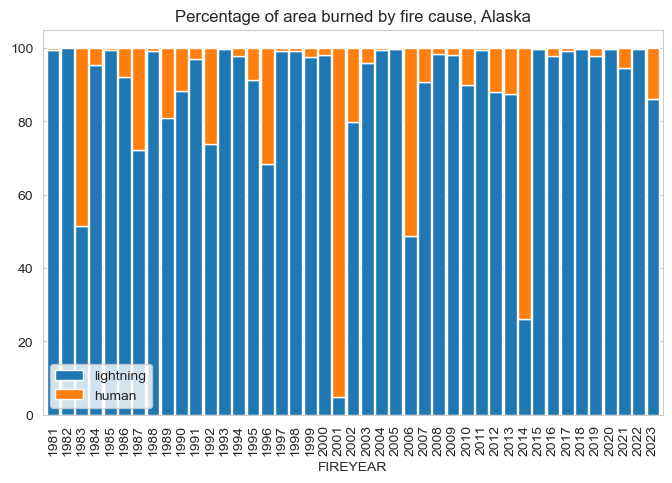

In [ ]:

ax = aggDF.set_index('FIREYEAR')[['lightning', 'human']].plot(
    kind='bar', stacked=True, figsize=(8, 5), width=.9)
sns.move_legend(ax, "lower left")
ax.xaxis.grid(False)
ax.set_title("Percentage of area burned by fire cause, Alaska")

Text(0.5, 1.0, 'Area burned by fire cause, Alaska')

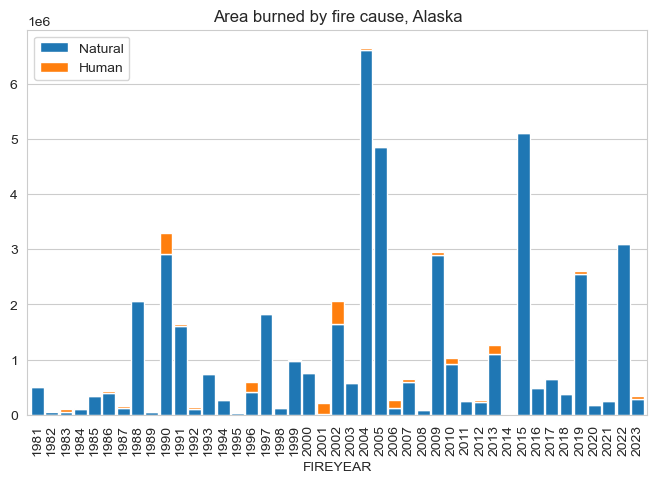

In [ ]:
ax = aggDF.set_index('FIREYEAR')[['Natural', 'Human']].plot(
    kind='bar', stacked=True, figsize=(8, 5), width=.9)
sns.move_legend(ax, "upper left")
ax.xaxis.grid(False)
ax.set_title("Area burned by fire cause, Alaska")

Percentage area burned 2004-2023

In [ ]:
aggDF[aggDF.FIREYEAR.astype(int) > 2003].Natural.sum() / aggDF[aggDF.FIREYEAR.astype(int) > 2003].totalacres.sum()

0.975007587286456

Since 1981

In [ ]:
aggDF.Natural.sum() / aggDF.totalacres.sum()

0.9520402398467785